## Функции обработки видео-кадров

In [2]:
import cv2, time
import numpy as np
import matplotlib.pyplot as plt

# Расчёт дифференциальных сумм для соседних кадров попиксельно (не информативно)
def diffsums(img_1, img_2):
    diffsum = 0
    for i in range(0, len(img_1), 10):           
        for j in range(0, len(img_1[i]), 10):
            diffsum = diffsum + abs(int(img_2[i][j][0]) - int(img_1[i][j][0])) + \
                                abs(int(img_2[i][j][1]) - int(img_1[i][j][1])) + \
                                abs(int(img_2[i][j][2]) - int(img_1[i][j][2]))
    return diffsum

# Расчёт дифференциальных сумм для соседних кадров по ячейкам

# rgb-значения пикселей в ячейке складываются вместе
# диф. сумма зависит от изменения интегральных яркостей ячеек
def cell_diffsums(img_1, img_2):
    diffsum = 0
    l_y = int(len(img_1)/10)      # размер ячеек по вертикали
    l_x = int(len(img_1[0])/10)   # размер ячеек по горизонтали
    for i in range(0, len(img_1)-l_y, l_y):           
        for j in range(0, len(img_1[0])-l_x, l_x):
            cell_diffsum = 0
            for ii in range(i, i+l_y, int(l_y/10)):
                for jj in range(j, j+l_x, int(l_x/10)):
                    cell_diffsum += int(img_2[ii][jj][0]) - int(img_1[ii][jj][0]) + \
                                    int(img_2[ii][jj][1]) - int(img_1[ii][jj][1]) + \
                                    int(img_2[ii][jj][2]) - int(img_1[ii][jj][2]) 
            diffsum += abs(cell_diffsum) 
    return diffsum

# rgb-значения пикселей в ячейке складываются по отдельности 
# диф. сумма зависит от изменения цветов в ячейках, в т.ч. при неизменной интегральной яркости

def cell_diffsums_2(img_1, img_2, n, m):
    diffsum = 0
    l_y = int(len(img_1)*n)         # размер ячеек по вертикали
    l_x = int(len(img_1[0])*n)      # размер ячеек по горизонтали    
    for i in range(0, len(img_1)-l_y, l_y):           
        for j in range(0, len(img_1[0])-l_x, l_x):             
            cell_sums_1, cell_sums_2 = [0, 0, 0], [0, 0, 0]
            for ii in range(i, i+l_y, int(l_y*m)):      # шаг сетки контрольных точек по вертикали
                for jj in range(j, j+l_x, int(l_x*m)):  # шаг сетки контрольных точек по горизонтали           
                    cell_sums_1[0] += int(img_1[ii][jj][0])
                    cell_sums_2[0] += int(img_2[ii][jj][0])
                    cell_sums_1[1] += int(img_1[ii][jj][1])
                    cell_sums_2[1] += int(img_2[ii][jj][1])
                    cell_sums_1[2] += int(img_1[ii][jj][2])
                    cell_sums_2[2] += int(img_2[ii][jj][2])

            diffsum += abs(cell_sums_2[0] - cell_sums_1[0]) + abs(cell_sums_2[1] - cell_sums_1[1]) + \
                            abs(cell_sums_2[2] - cell_sums_1[2])
    
    return diffsum

# используются перекрытия ячеек (задаются смещениями sx, sy) - для обнаружения малых смещений объектов на фоне шума

def cell_diffsums_3(img_1, img_2, n, m, sx, sy):
    diffsums = []
    l_y = int(len(img_1)*n)         # размер ячеек по вертикали
    l_x = int(len(img_1[0])*n)      # размер ячеек по горизонтали    
    for i in range(0, len(img_1)-l_y, int(l_y*sy)):           
        for j in range(0, len(img_1[0])-l_x, int(l_x*sx)):             
            cell_sums_1, cell_sums_2 = [0, 0, 0], [0, 0, 0]
            for ii in range(i, i+l_y, int(l_y*m)):      # шаг сетки контрольных точек по вертикали
                for jj in range(j, j+l_x, int(l_x*m)):  # шаг сетки контрольных точек по горизонтали           
                    cell_sums_1[0] += int(img_1[ii][jj][0])
                    cell_sums_2[0] += int(img_2[ii][jj][0])
                    cell_sums_1[1] += int(img_1[ii][jj][1])
                    cell_sums_2[1] += int(img_2[ii][jj][1])
                    cell_sums_1[2] += int(img_1[ii][jj][2])
                    cell_sums_2[2] += int(img_2[ii][jj][2])

            diffsums.append(abs(cell_sums_2[0] - cell_sums_1[0]) + abs(cell_sums_2[1] - cell_sums_1[1]) + \
                            abs(cell_sums_2[2] - cell_sums_1[2]))   
    return max(diffsums)

## Один видео-файл

In [50]:
# обработка cell_diffsums

cap = cv2.VideoCapture('./test_video/детекция движения/307_test/из файла/307.mp4') 

t1 = time.time()

fps = 30   # число кадров в секунду
t, ds = [], []
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/5)
for k in range(0, frame_count - round(fps), round(fps)):                 # обработка примерно одного кадра в секунду
    cap.set(1, k)                                                        # (1, номер кадра - 1)
    ret, frame_1 = cap.read()
    cap.set(1, k + round(fps))
    ret, frame_2 = cap.read()
    diffsum = cell_diffsums(frame_1, frame_2)
    t.append(int(k/fps))
    ds.append(diffsum)
    
    '''im = cv2.resize(frame, (960, 540)) 
    cv2.imshow('test', im)
    if cv2.waitKey(1) & 0xFF == ord('q'): break'''
               
cap.release()
cv2.destroyAllWindows()
t2 = time.time()

print('длительность видео-фрагмента, m-s:', str(t[-1]//60) + '-' + str(t[-1]%60))
print('длительность обработки, m-s:', str(round(t2 - t1)//60) + '-' + str(round(t2 - t1)%60))

длительность видео-фрагмента, m-s: 2-20
длительность обработки, m-s: 0-42


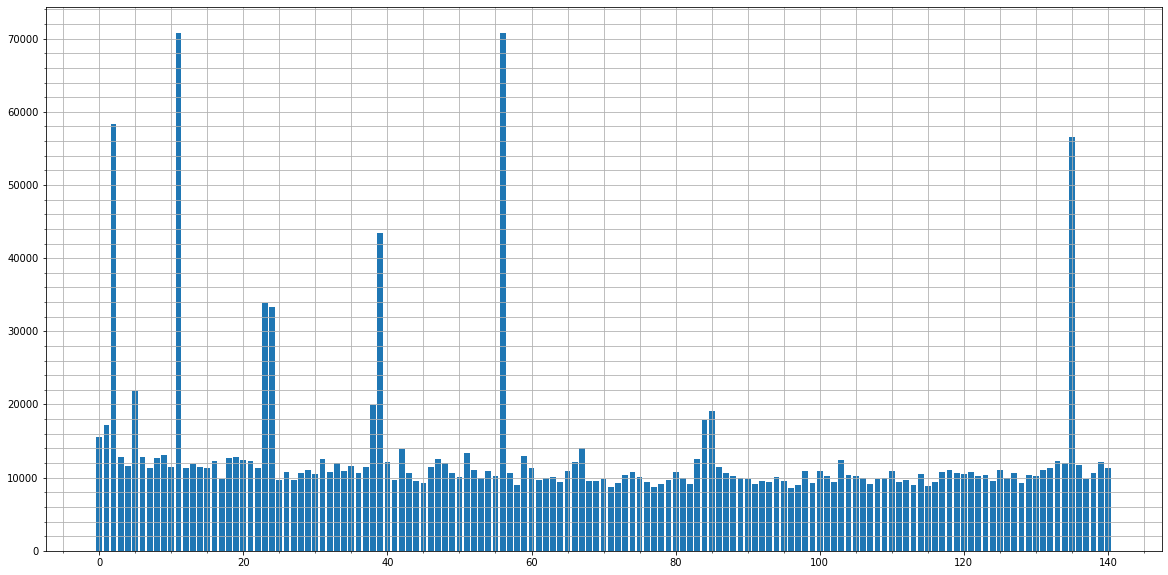

In [51]:
# Вывод данных в заданном диапазоне на диаграмме
plt.figure(figsize=(20, 10))
plt.minorticks_on()
plt.grid(True, which='both')
n_1, n_2 = 0, len(t)
plt.bar(t[n_1:n_2], ds[n_1:n_2])

plt.show()

In [12]:
# обработка cell_diffsums_2, cell_diffsums_3

cap = cv2.VideoCapture('./test_video/детекция движения/307_test/из файла/307.mp4') 

t1 = time.time()

fps = 30.04  # число кадров в секунду
n = 0.1
m = 0.2
t, ds2, ds3 = [], [], []

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for k in range(0, frame_count - round(fps), round(fps*0.2)):                 # обработка кадров с заданным шагом
    cap.set(1, k)                                                          # (1, номер кадра - 1)
    ret, frame_1 = cap.read()
    cap.set(1, k + round(fps*0.2))                                           # задержка между кадрами
    ret, frame_2 = cap.read()
    #diffsum2 = cell_diffsums_2(frame_1, frame_2, n, m)
    diffsum3 = cell_diffsums_3(frame_1, frame_2, n, m, 0.25, 1)
    t.append(round(k/fps, 2))
    #ds2.append(diffsum2)
    ds3.append(diffsum3)
    
    '''im = cv2.resize(frame, (960, 540)) 
    cv2.imshow('test', im)
    if cv2.waitKey(1) & 0xFF == ord('q'): break'''
               
cap.release()
cv2.destroyAllWindows()
t2 = time.time()

print('длительность видео-фрагмента, m-s:', str(t[-1]//60) + '-' + str(t[-1]%60))
print('длительность обработки, m-s:', str(round(t2 - t1)//60) + '-' + str(round(t2 - t1)%60))

длительность видео-фрагмента, m-s: 1.0-28.08
длительность обработки, m-s: 0-55


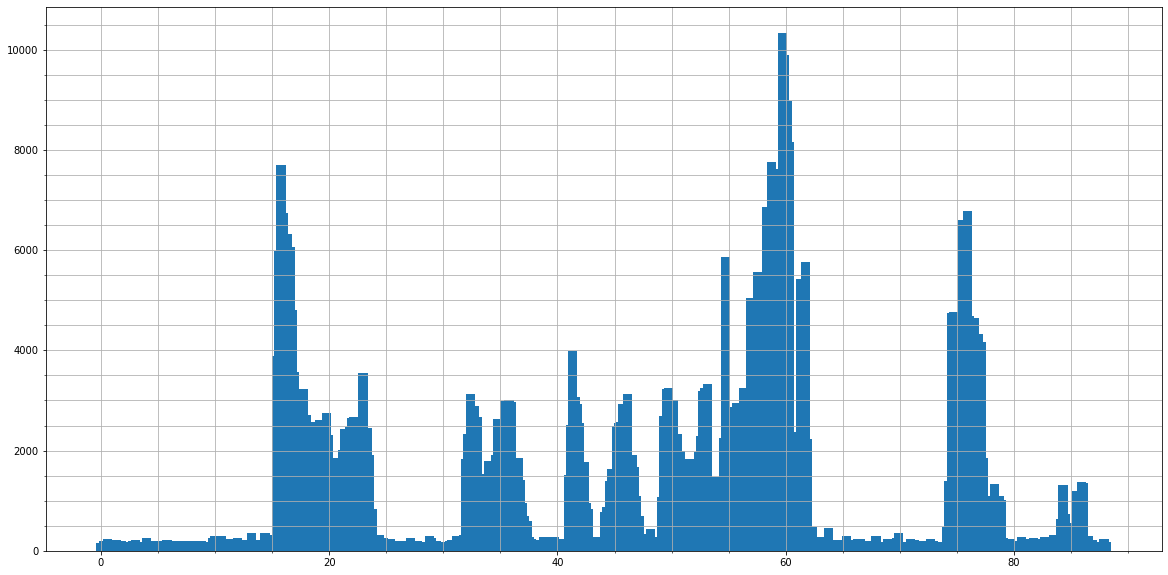

In [13]:
# Вывод данных в заданном диапазоне на диаграмме
plt.figure(figsize=(20, 10))
plt.minorticks_on()
plt.grid(True, which='both')
n_1, n_2 = 0, len(t)
#plt.bar(t[n_1:n_2], ds2[n_1:n_2])
plt.bar(t[n_1:n_2], ds3[n_1:n_2])
plt.show()

## Видео-стрим

In [2]:
# 2 параллельных потока, обращающихся к массиву кадра (frame) + mutex
# обработка кадров функцией cell_diffsums_2

import threading

cap = cv2.VideoCapture('rtsp://192.168.13.133:8554/test')

T = time.time()     # время захвата стрима
mutex = threading.Lock()

ret = True
frame, t, ds = [], [], []
n = 0.01    # относительный размер ячеек
m = 0.2    # относительный шаг контрольных точек в ячейках
d = 0.2    # задержка между кадрами в паре
sx = 1     # шаг смещения ячеек по горизонтали
sy = 1     # шаг смещения ячеек по вертикали

def frame_reading():
    global t_cur, ret, frame, dt
    while True: 
        with mutex:
            t_cur = time.time()  # текущее время
            dt = round(t_cur - T, 3)
            ret, frame = cap.read()   
            if not ret: break 
        #im = cv2.resize(frame, (960, 540)) 
        #cv2.imshow('video feed', im) 
        if (cv2.waitKey(1) & 0xFF == ord('q')) or dt > 85:
            ret = False
            break   
    cap.release()
    cv2.destroyAllWindows()
    
def frame_processing():
    global t, dt, ds
    while True:
        if not ret: break
        if not len(frame): continue   
        frame_1 = frame
        time.sleep(d)    # задержка между обрабатываемыми кадрами
        frame_2 = frame
        diffsum = cell_diffsums_2(frame_1, frame_2, n, m)
        #diffsum = cell_diffsums_3(frame_1, frame_2, n, m, sx, sy)
        t.append(dt)
        ds.append(diffsum) 

        
th1 = threading.Thread(target=frame_reading)
th2 = threading.Thread(target=frame_processing)

th1.start()
th2.start()

th1.join()
th2.join()

[rtsp @ 0x1b22f80] method SETUP failed: 461 Client error
[h264 @ 0x1b36400] co located POCs unavailable
[h264 @ 0x2351340] co located POCs unavailable
[h264 @ 0x2db97c0] co located POCs unavailable
[h264 @ 0x2418e80] mmco: unref short failure
[h264 @ 0x2331b00] error while decoding MB 99 63, bytestream -7


start stream: 2022-08-04 15:03:01
stop stream: 2022-08-04 15:04:26
количество диф. сумм: 77
относительный размер ячеек: 0.01
относительный шаг смещения ячеек по горизонтали и вертикали: 1 ; 1
относительный шаг сетки контрольных точек в ячейках: 0.2
задержка между кадрами в паре, c: 0.2


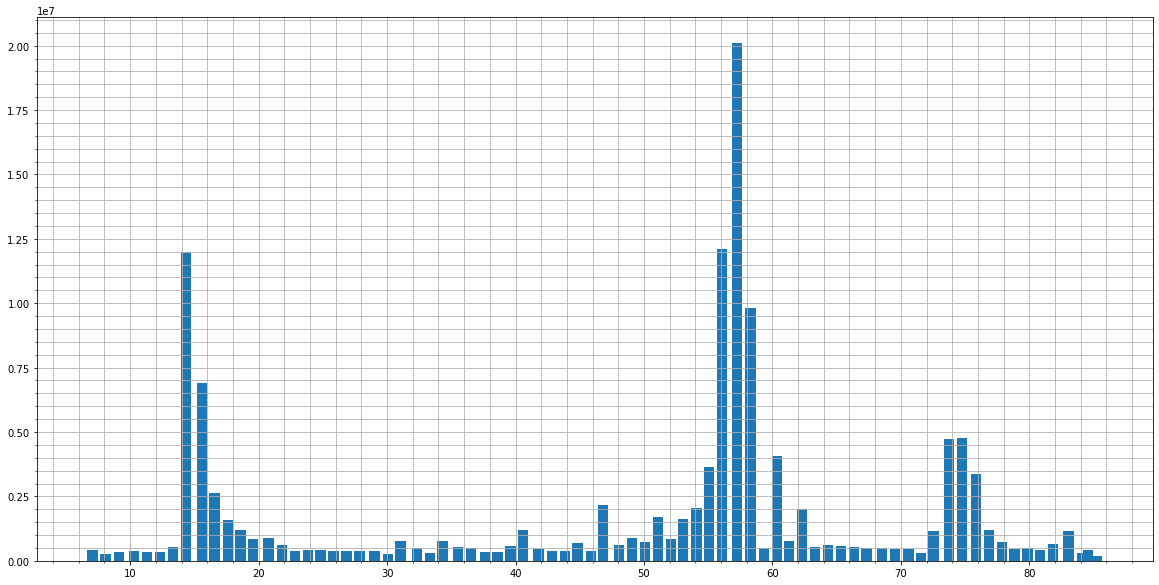

In [3]:
# Вывод данных в заданном диапазоне на диаграмме

# Временной диапазон захвата видеопотока
import datetime
ts_1, ts_2 = int(T), int(t_cur)
print('start stream:', datetime.datetime.fromtimestamp(ts_1).strftime('%Y-%m-%d %H:%M:%S'))
print('stop stream:', datetime.datetime.fromtimestamp(ts_2).strftime('%Y-%m-%d %H:%M:%S'))

plt.figure(figsize=(20, 10))
plt.minorticks_on()
plt.grid(True, which='both')
n_1, n_2 = 0, len(t)
print('количество диф. сумм:',len(t))
print('относительный размер ячеек:', n)
print('относительный шаг смещения ячеек по горизонтали и вертикали:', sx, ';', sy)
print('относительный шаг сетки контрольных точек в ячейках:', m)
print('задержка между кадрами в паре, c:', d)
plt.bar(t[n_1:n_2], ds[n_1:n_2])

plt.show()